In [1]:
from TRIOMA.tools.Extractors.PAV import Component,Fluid,Membrane, Geometry
import numpy as np 
import TRIOMA.tools.correlations as corr
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from TRIOMA.tools.BreedingBlanket import BreedingBlanket

This analysis is a sweep on two parameters, in which the efficiency evaluated with the nodal model and the analytical efficiency are compared together, and the relative error in percentage is given. First we define the d_hyd_v, the first sweep vector. This is going to be sweeped against all others (otherwise the analysis would be very long if we sweep all vectors against each other). Then we define a vector of vectors to sweep. A str_v_vec is used in the "update_attribute" method to indicate which attribute is going to be updated, corresponding with the vector that is sweeped in the loop. The Fluid_v_bool vector is used in this code to check if the update attribute must be used for the Component class or the Component.fluid class. The same happens for the solid_v_bool. Color vectors will be used after for plotting contours. Eff_v_vec is used then to store the results.

In [2]:
##Define sweep vectors
color_vector = ["red", "blue", "green", "yellow", "purple", "orange"]
N_vec=15
d_hyd_v=np.logspace(np.log10(20.5E-3),np.log10(20E-2),N_vec)
T_vec=np.linspace(800,1000,N_vec)
U0_vec=np.linspace(1,5,N_vec)
str_v_vec=['T','U0','Solubility','c_in',"thick","K_S","k_d","k_r"]
c_in_vec=np.logspace(-6,-1,N_vec)
D_vec=np.logspace(-10,-8,N_vec)
thick_vec=np.logspace(-3,-1,N_vec)
K_S_vec=np.logspace(-3,-1,N_vec)
k_d_vec=np.logspace(2,6,N_vec)
k_r_vec=np.logspace(2,6,N_vec)
solubility_vec=np.logspace(-3,-1,N_vec)
v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec,  thick_vec, K_S_vec])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , True , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])

Here variables for the Breeding Blanket class are defined. 

In [3]:
T_hot_prim=900
T_hot_sec=838
T_cold_prim=800
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*(T_sec_ave-273.15)+3.49E-7*(T_sec_ave-273.15)**2-1.474E-10*(T_sec_ave-273.15)**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=3
Q=1E9
m_in_sec=Q/(cp_sec*(T_hot_sec-T_cold_sec))

Empty arrays to store results with the append method are defined, and the double sweep takes place. In each iteration, the same component is defined and then one attribute is changed according to the sweep. Then color map plots are displayed, with additional isovariable contours.  

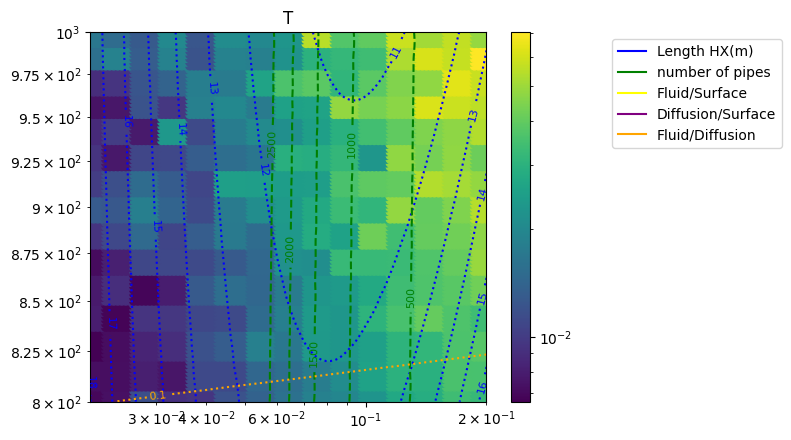

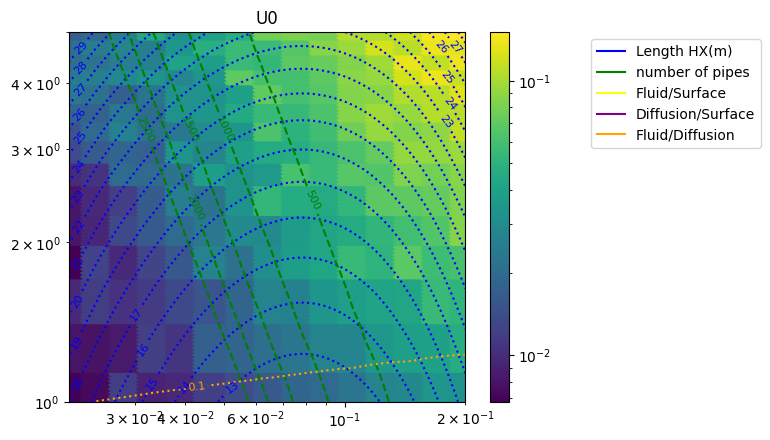

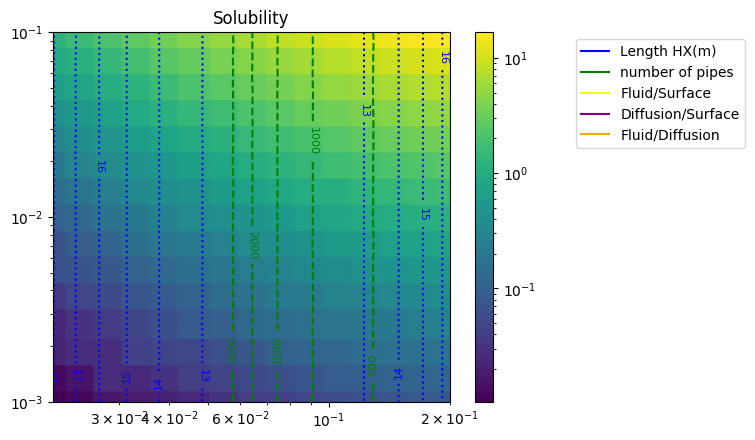

c:\Users\Gabriele\anaconda3\envs\testenv\Lib\site-packages\TRIOMA\tools\Extractors\PAV.py:941: RuntimeWarning: invalid value encountered in sqrt
  * ((c_wl / self.fluid.Solubility) ** 0.5 - p_out**0.5)


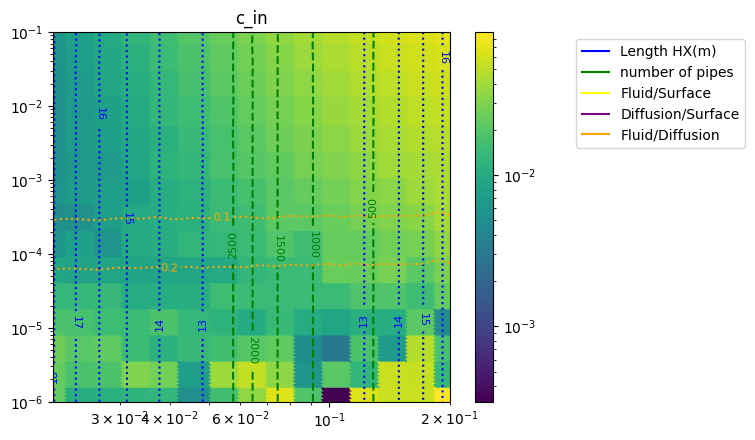

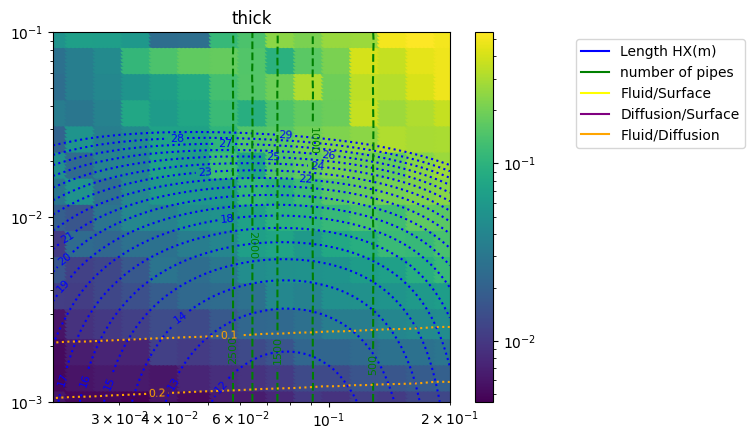

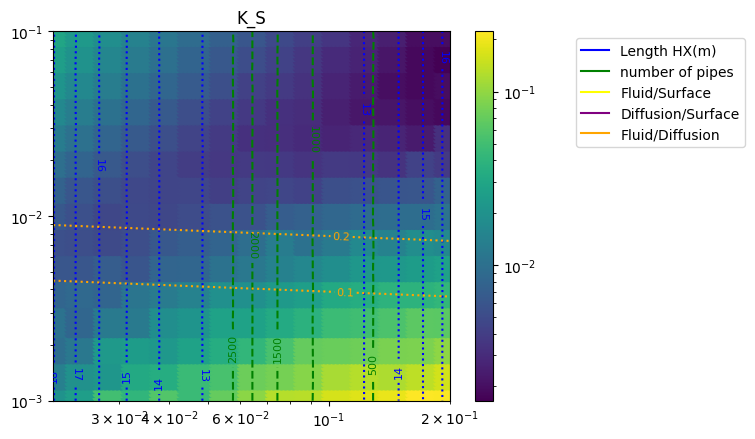

In [4]:
for j,vec in enumerate(v_vec):
        eff_v=np.array([])
        var_str=str_v_vec[j]
        T=800
        res_vec=np.array([])
        d_hyd_v_res=np.array([])
        var_vec=np.array([])
        L_vec=np.array([])
        n_pipes_v=np.array([])
        H_v=np.array([])
        W_v=np.array([])
        for var in vec:
                for i,d_hyd in enumerate(d_hyd_v):
                        if str_v_vec[j]=='T':
                                T=var
                        mat=materials.Flibe(T)
                        flibe=Fluid(T=T, Solubility=mat.Solubility, MS=True,D=mat.D, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1,k=mat.k,
                         cp=mat.cp)
                        geom_PAV=Geometry(L=1,D=d_hyd,thick=2.1E-3,n_pipes=1)
                        BB=BreedingBlanket(Q=Q,TBR=1.08,T_out=T_hot_prim,T_in=T_cold_prim,fluid=flibe ,c_in=1E-4)
                        BB.get_cout()
                        c0=BB.c_out
                        Steel = Membrane( T=T,
                                D=7E-10,
                                thick=2.1E-3,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        PAV = Component(c_in=c0, geometry=geom_PAV,eff=0.5, fluid=flibe, membrane=Steel)
                        if fluid_v_bool[j]==True:
                                PAV.fluid.update_attribute(var_str,var)
                        elif solid_v_bool[j]==True:
                                PAV.membrane.update_attribute(var_str,var)
                        else:
                                PAV.update_attribute(var_str,var)
                        n_pipes=BB.m_coolant/(PAV.fluid.rho*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        Q_HX=Q/n_pipes/N_HX
                        HX=Component(c_in=PAV.outlet_c_comp(), eff=0.08, fluid=flibe, geometry=geom_PAV, membrane=None)
                        PAV.get_adimensionals()
                        d_h_sec=2.5E-2 # from HX forecasts
                        V_sec=m_in_sec/(rho_sec*d_h_sec**2*np.pi/4)/N_HX/n_pipes
                        Re_sec=corr.Re(rho=rho_sec,u=V_sec,mu=mu_sec,L=d_h_sec)
                        Pr_sec=corr.Pr(c_p=cp_sec,mu=mu_sec,k=k_sec)
                        h_coeff_sec=corr.get_h_from_Nu(corr.Nu_DittusBoelter(Re_sec, Pr_sec), k_sec,d_h_sec)
                        R_sec=1/h_coeff_sec
                        U = PAV.get_global_HX_coeff(R_sec)
                        L= corr.get_length_HX(corr.get_deltaTML(T_hot_prim, T_cold_prim, T_cold_sec, T_hot_sec), PAV.fluid.d_Hyd, PAV.U, Q_HX)
                        PAV.update_attribute('L',L)
                        PAV.get_efficiency(plotvar=False)
                        PAV.analytical_efficiency()
                        out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        eff_v=np.append(eff_v, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                        d_hyd_v_res=np.append(d_hyd_v_res, d_hyd)
                        var_vec=np.append(var_vec, var)
                        res_vec=np.append(res_vec, abs(PAV.eff-PAV.eff_an)/PAV.eff_an)
                        L_vec=np.append(L_vec, L)
                        n_pipes_v=np.append(n_pipes_v, n_pipes)
                        H_v=np.append(H_v, PAV.H)
                        W_v=np.append(W_v, PAV.W)
                eff_v_vec=np.append(eff_v_vec, eff_v)
        plt.figure(j)
        plt.title(str_v_vec[j])
        plt.yscale('log')
        plt.xscale('log')
        x = np.logspace(np.log10(min(d_hyd_v_res[:])), np.log10(max(d_hyd_v_res[:])), num=100)
        y = np.logspace(np.log10(min(var_vec[:])), np.log10(max(var_vec[:])), num=100)
        X, Y = np.meshgrid(x, y)
        Z = griddata((d_hyd_v_res, var_vec), (res_vec)*100, (X, Y), method='nearest')
        dZdX, dZdY = np.gradient(Z, x, y, edge_order=2)
        ZL=griddata((d_hyd_v_res, var_vec), L_vec, (X, Y), method='cubic')
        Zn_pipes=griddata((d_hyd_v_res, var_vec), n_pipes_v, (X, Y), method='cubic')
        ZH=griddata((d_hyd_v_res, var_vec), H_v, (X, Y), method='cubic')
        ZW=griddata((d_hyd_v_res, var_vec), W_v, (X, Y), method='cubic')
        Zratio=griddata((d_hyd_v_res, var_vec), H_v/W_v, (X, Y), method='cubic')
        
        #contour1=plt.contour(X, Y, Z, levels=[1E-4,1E-3,1E-2,1E-1,1,10],norm=LogNorm(),colors=color_vector[0])
        contour2=plt.contour(X, Y, ZL, levels=range(1,30,1),colors=color_vector[1],linestyles='dotted')
        contour3=plt.contour(X, Y, Zn_pipes, levels=range(500,3000,500),colors=color_vector[2],linestyles='dashed')
        contour4=plt.contour(X, Y, ZH, levels=[0.1,0.2,10,20],colors=color_vector[3],linestyles='dotted')
        contour5=plt.contour(X, Y, ZW, levels=[0.1,0.2,10,20],colors=color_vector[4],linestyles='dotted')
        contour6=plt.contour(X, Y, Zratio, levels=[0.1,0.2,10,20],colors=color_vector[5],linestyles='dotted')
        scatter=plt.scatter(X,Y, c=Z ,norm=colors.LogNorm()) 
        #plt.clabel(contour1, inline=True, fontsize=8)
        plt.clabel(contour2, inline=True, fontsize=8)
        plt.clabel(contour3, inline=True, fontsize=8)
        plt.clabel(contour4, inline=True, fontsize=8)
        plt.clabel(contour5, inline=True, fontsize=8)
        plt.clabel(contour6, inline=True, fontsize=8)
        if scatter:
                if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                        plt.colorbar(scatter)  # Show color scale for scatter
                else:
                        print("Cannot create colorbar: data does not have a valid range of values.")
        #line1 = mlines.Line2D([], [], color=color_vector[0], markersize=15, label='Concentration Losses [%]')
        line2 = mlines.Line2D([], [], color=color_vector[1], markersize=15, label='Length HX(m)')
        line3 = mlines.Line2D([], [], color=color_vector[2], markersize=15, label='number of pipes')
        line4 = mlines.Line2D([], [], color=color_vector[3], markersize=15, label='Fluid/Surface')
        line5 = mlines.Line2D([], [], color=color_vector[4], markersize=15, label='Diffusion/Surface')
        line6= mlines.Line2D([], [], color=color_vector[5], markersize=15, label='Fluid/Diffusion')
        #plt.legend(handles=[ line1,line2, line3], loc='upper right')
        plt.legend(handles=[ line2, line3,line4,line5,line6], bbox_to_anchor=(1.3, 1), loc='upper left')
        plt.show()